This is a demonstration of multiple subplots of impervious surface proportion per grid cell using matplotlib. 

In [ ]:
import rasterio as rio
import time as tm
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterstats as rs
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import normalize, MinMaxScaler

warnings.filterwarnings("ignore")


The objective of this script is to plot the cumulative frequency impervious surface pixels within each grid cell of the study area.

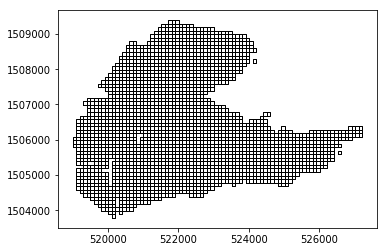

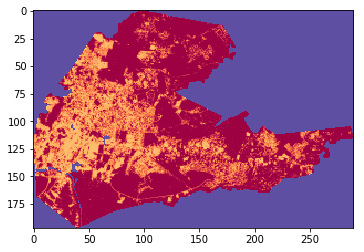

In [21]:
"""
http://stackoverflow.com/questions/15408371/cumulative-distribution-plots-python
http://matplotlib.org/examples/statistics/histogram_demo_cumulative.html

Cumulative frequency plots of impervious surfaces
per training grid cell.
"""

img_dir = 'resampled.tif'
grid_dir = 'grid100.tif'
sa_grid_dir = 'study_area\\study_area.shp'

img = rio.open(img_dir)
grid = rio.open(grid_dir)
pgrid_dir = gpd.read_file(sa_grid_dir)

data = img.read(1)
grid = grid.read(1)
pgrid = pgrid_dir

# plot study area grid
pgrid.head()
pgrid.plot(color='white')
plt.show()

# plot raster image of impervious surface proportions
plt.imshow(data, cmap='Spectral' )
plt.show()

In [ ]:

tr_cell_i = pgrid[pgrid['lu_code']!= 0].index

# isolate training grid cells
for i, cell_i in enumerate(tr_cell_i):

    data[data>=1] = np.nan
    cell_pix = data[grid==cell_i]
    cell_pix = cell_pix[~np.isnan(cell_pix)] # filter out nodata pixels
    lu_type = pgrid.loc[cell_i, 'lu_type']

    # ignore cells with pixel values of nan
    if len(cell_pix) > 0:

        # scale cell pixels from (0,1)
        scaler = MinMaxScaler()
        cell_pix_norm = scaler.fit_transform(cell_pix)

        plt.figure()
        plt.subplot()
        n, bins, patches = plt.hist(cell_pix_norm, bins=50, histtype='step', normed=1,
                               cumulative=True, facecolor='g', label='Empirical')

        #########################################

        # cumulative frequency plotting parameters
        mu = cell_pix_norm.mean()
        sigma = cell_pix_norm.std()
       
        # reference for multiple plots in a grid
        # http://stackoverflow.com/questions/9603230/how-to-use-matplotlib-tight-layout-with-figure
        
        # plot the theoretical cumulative frequency
        y = mlab.normpdf(bins, mu, sigma).cumsum()
        y /= y[-1]
        y[np.isnan(y)] = 0.
        y_norm = scaler.fit_transform(y)

        plt.plot(bins, y_norm, 'k--', linewidth=1.5, label='Theoretical')
        # ax.set_ylabel('Cumulative frequency')
        # ax.set_xlabel('Proportion impervious surface')
        # ax.set_ylim([0., 1.2])
        # ax.set_xlim([-0.2, 1.])
        plt.title(str(lu_type) + ' ' + str(cell_i))
plt.tight_layout()
# plt.show()


